# Computer Vision Homework 3

Questions 1, 2, 3

Amirkabir University of Technology

Dr. Safabakhsh

By Gholamreza Dar 400131018

Fall 2022


## Imports

In [14]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style('dark')

import os
import datetime

## Functions

In [15]:
def rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def bgr(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def disp(img, title='', s=8, vmin=None, vmax=None):
    plt.figure(figsize=(s,s))
    plt.axis('off')
    if vmin is not None and vmax is not None:
        plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()

def uint8ify(img):
    img -= img.min()
    img /= img.max()
    img *= 255
    return np.uint8(img)

def overlay(a,b):
    # a and b should be float images and between 0-1

    mask = a >= 0.5 # generate boolean mask of everywhere a > 0.5 
    ab = np.zeros_like(a) # generate an output container for the blended image 

    # now do the blending 
    ab[~mask] = (2*a*b)[~mask] # 2ab everywhere a<0.5
    ab[mask] = (1-2*(1-a)*(1-b))[mask] # else this
    
    return ab

def before_after(img_a, img_b, name='', vmin=None, vmax=None, effect_name='Processed', figsize=(10,4)):
    fig, axs = plt.subplots(1,2, constrained_layout=True, figsize=figsize)
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].set_title(f'{name} Original')
    axs[1].set_title(f'{name} {effect_name}')
    if vmin is not None and vmax is not None:
        axs[0].imshow(img_a, cmap='gray', vmin=vmin, vmax=vmax)
        axs[1].imshow(img_b, cmap='gray', vmin=vmin, vmax=vmax)
    else:
        axs[0].imshow(img_a, cmap='gray')
        axs[1].imshow(img_b, cmap='gray')
    plt.show()

## Load Images

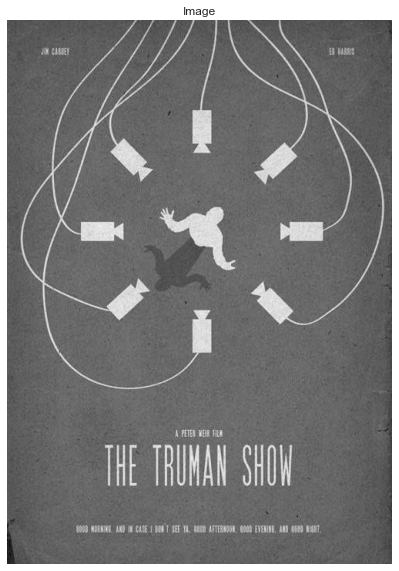

In [16]:
image = cv2.imread('data/img.jpeg', 0)
image_rgb = rgb(cv2.imread('data/img.jpeg'))

disp(image, 'Image', s=10)

## 1 - Otsu's Method

### OpenCV Otsu for reference

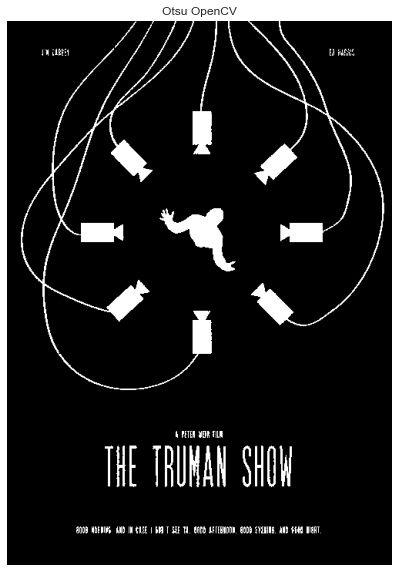

In [17]:
# opencv otsu thresholding
otsu_opencv = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
disp(otsu_opencv, 'Otsu OpenCV', s=10)

### Implementing Otsu's Method

In [18]:
#src: https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html
def otsu_thresholding(img):
    # find normalized_histogram, and its cumulative distribution function
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    hist_norm = hist.ravel()/hist.sum()
    Q = hist_norm.cumsum()
    bins = np.arange(256)
    fn_min = np.inf
    thresh = -1
    for i in range(1,256):
        p1,p2 = np.hsplit(hist_norm,[i]) # probabilities
        q1,q2 = Q[i],Q[255]-Q[i] # cum sum of classes
        if q1 < 1.e-6 or q2 < 1.e-6:
            continue
        b1,b2 = np.hsplit(bins,[i]) # weights
        # finding means and variances
        m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
        v1,v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2
        # calculates the minimization function
        fn = v1*q1 + v2*q2
        if fn < fn_min:
            fn_min = fn
            thresh = i
    return thresh, img >= thresh


### Image 1

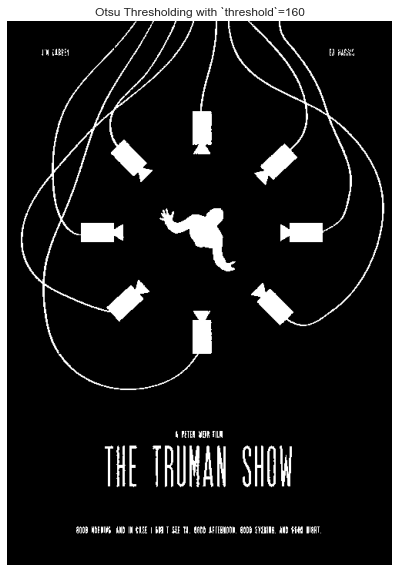

In [35]:
# using otsu_thresholding() function
img = cv2.imread('data/img.jpeg',0)
image_rgb = rgb(cv2.imread('data/img.jpeg'))
# blur = cv2.GaussianBlur(img,(5,5),0)
thresh, ret = otsu_thresholding(img)
disp(ret, f'Otsu Thresholding with `threshold`={thresh}', s=10)

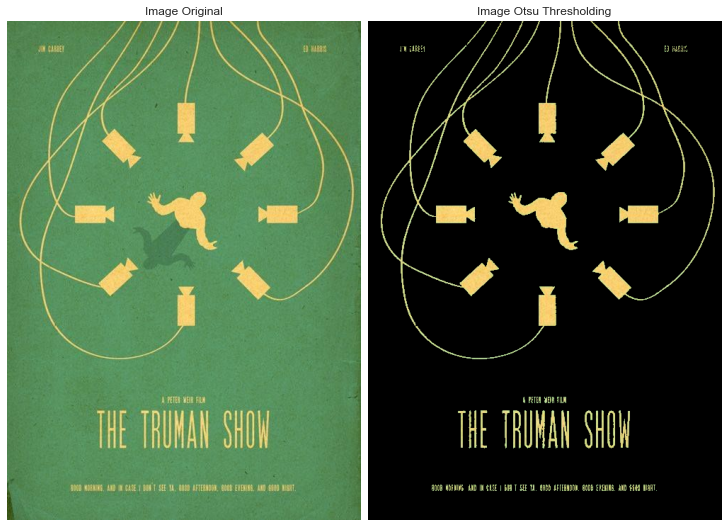

In [20]:
# mask original image with otsu thresholding
mask = ret.astype(np.uint8)
masked = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)
before_after(image_rgb, masked, name='Image', effect_name='Otsu Thresholding', figsize=(10,10))

### Image 2

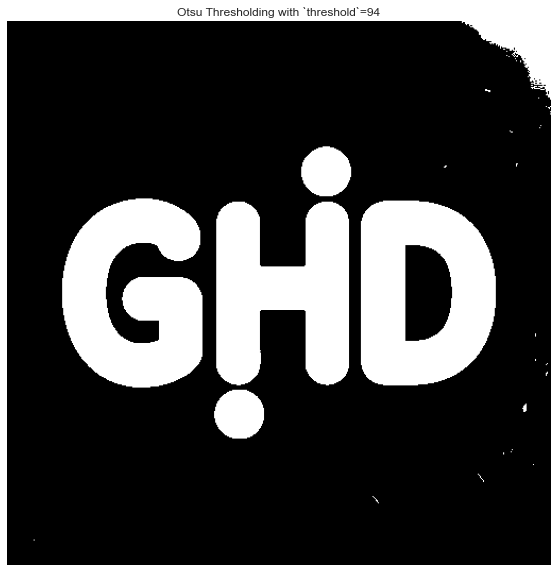

In [185]:
# using otsu_thresholding() function
img = cv2.imread('data/ghd.jpg',0)
image_rgb = rgb(cv2.imread('data/ghd.jpg'))
# blur = cv2.GaussianBlur(img,(1,1),0)
thresh, ret = otsu_thresholding(img)
disp(ret, f'Otsu Thresholding with `threshold`={thresh}', s=10)

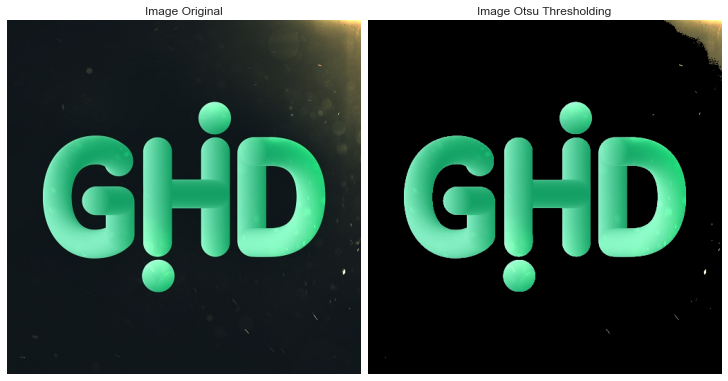

In [186]:
# mask original image with otsu thresholding
mask = ret.astype(np.uint8)
masked = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)
before_after(image_rgb, masked, name='Image', effect_name='Otsu Thresholding', figsize=(10,10))

## 2 - Iterative Method

### Implementing Iterative Method

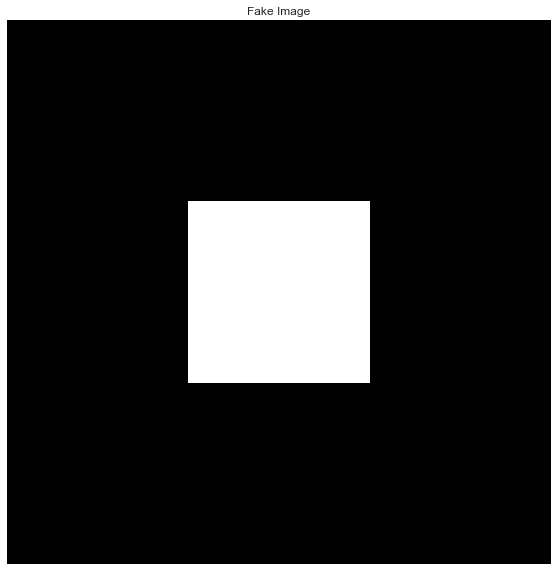

Converged to t=127.5 after 2 iterations


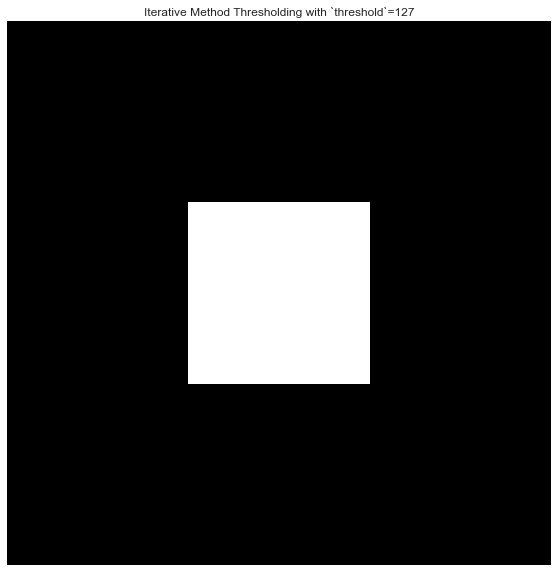

In [175]:
# src: Gholamreza Dar 2022
def iterative_method_thresholding(img, max_iter=200, debug=True):
    # bg is initialy the four corners of the image
    bg = [img[0,0], img[0,-1], img[-1,0], img[-1,-1]]
    mue_bg = np.mean(bg)

    # fg is every pixel except pixels in bg
    fg = np.delete(img, [[0,0], [0,-1], [-1,0], [-1,-1]])
    mue_fg = np.mean(fg)

    prev_t = 0
    for i in range(max_iter):
        # calculate new threshold
        t = (mue_bg + mue_fg) / 2

        # split image into foreground and background
        bg = img[img < t]
        fg = img[img >= t]

        # calculate new means
        mue_bg = np.mean(bg)
        mue_fg = np.mean(fg)

        if t == prev_t:
            if debug:
                print(f'Converged to t={t} after {i} iterations')
            break
    
        prev_t = t

    return t, img >= t

fake_image = np.zeros((30,30))
fake_image[10:20, 10:20] = 255

disp(fake_image, 'Fake Image', s=10)

thresh, ret = iterative_method_thresholding(fake_image)
disp(ret, f'Iterative Method Thresholding with `threshold`={int(thresh)}', s=10)

### Image 1

Converged to t=159.89226143318947 after 8 iterations


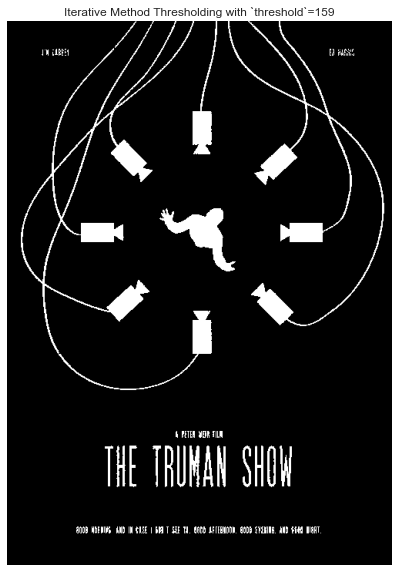

In [193]:
# using otsu_thresholding() function
img = cv2.imread('data/img.jpeg',0)
image_rgb = rgb(cv2.imread('data/img.jpeg'))
thresh, ret = iterative_method_thresholding(img)
disp(ret, f'Iterative Method Thresholding with `threshold`={int(thresh)}', s=10)

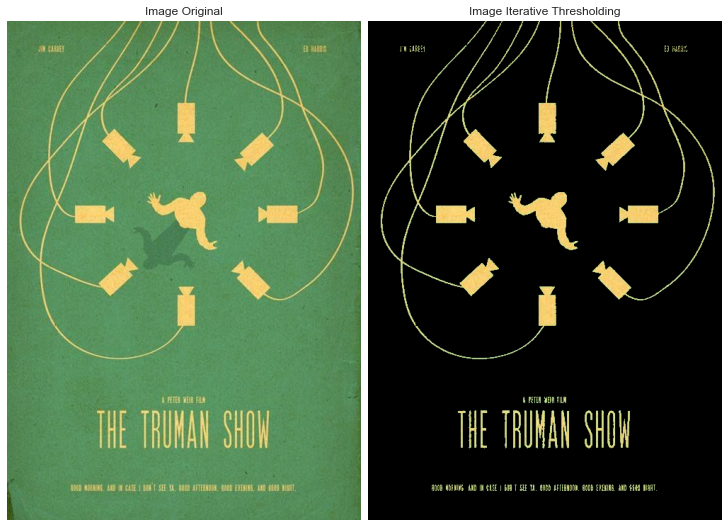

In [194]:
# mask original image with otsu thresholding
mask = ret.astype(np.uint8)
masked = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)
before_after(image_rgb, masked, name='Image', effect_name='Iterative Thresholding', figsize=(10,10))

### Image 2

Converged to t=93.18032036439126 after 5 iterations


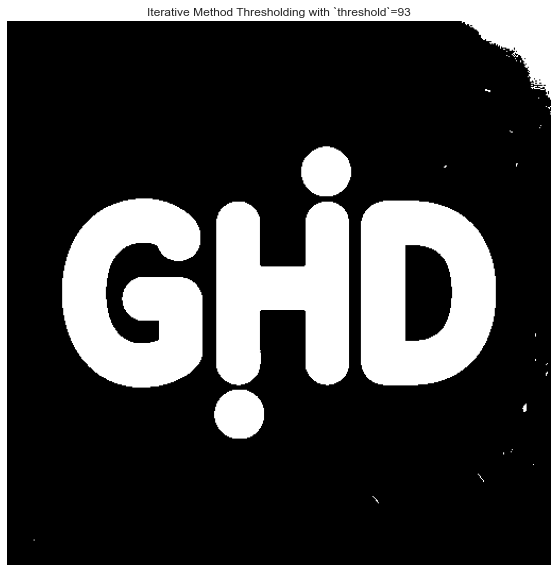

In [195]:
img = cv2.imread('data/ghd.jpg',0)
image_rgb = rgb(cv2.imread('data/ghd.jpg'))
thresh, ret = iterative_method_thresholding(img)
disp(ret, f'Iterative Method Thresholding with `threshold`={int(thresh)}', s=10)

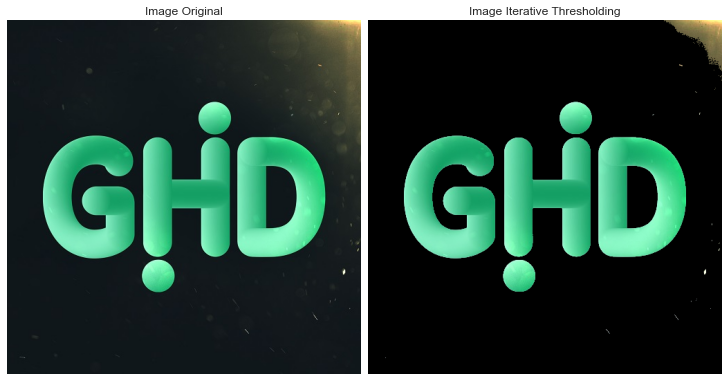

In [196]:
# mask original image with otsu thresholding
mask = ret.astype(np.uint8)
masked = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)
before_after(image_rgb, masked, name='Image', effect_name='Iterative Thresholding', figsize=(10,10))

## 3 - Speed Comparison

In [64]:
#src: https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html
def otsu_thresholding_no_ret(img):
    # find normalized_histogram, and its cumulative distribution function
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    hist_norm = hist.ravel()/hist.sum()
    Q = hist_norm.cumsum()
    bins = np.arange(256)
    fn_min = np.inf
    thresh = -1
    for i in range(1,256):
        p1,p2 = np.hsplit(hist_norm,[i]) # probabilities
        q1,q2 = Q[i],Q[255]-Q[i] # cum sum of classes
        if q1 < 1.e-6 or q2 < 1.e-6:
            continue
        b1,b2 = np.hsplit(bins,[i]) # weights
        # finding means and variances
        m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
        v1,v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2
        # calculates the minimization function
        fn = v1*q1 + v2*q2
        if fn < fn_min:
            fn_min = fn
            thresh = i
    return thresh


In [65]:
# src: Gholamreza Dar 2022
def iterative_method_thresholding_no_ret(img, max_iter=200):
    # bg is initialy the four corners of the image
    bg = [img[0,0], img[0,-1], img[-1,0], img[-1,-1]]
    mue_bg = np.mean(bg)

    # fg is every pixel except pixels in bg
    fg = np.delete(img, [[0,0], [0,-1], [-1,0], [-1,-1]])
    mue_fg = np.mean(fg)

    prev_t = 0
    for i in range(max_iter):
        # calculate new threshold
        t = (mue_bg + mue_fg) / 2

        # split image into foreground and background
        bg = img[img < t]
        fg = img[img >= t]

        # calculate new means
        mue_bg = np.mean(bg)
        mue_fg = np.mean(fg)

        if t == prev_t:
            # print(f'Converged to t={t} after {i} iterations')
            break
    
        prev_t = t

    return t

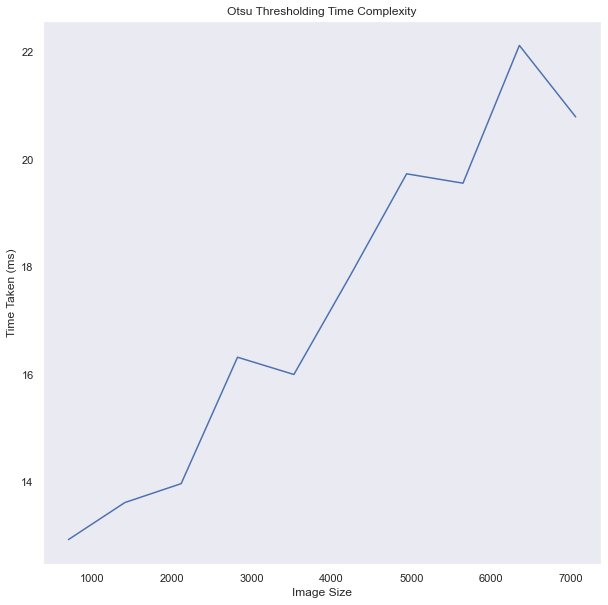

In [92]:
import time

otsu_times = []
sizes = []
num_tries = 100


img = cv2.imread('data/img.jpeg',0)
h, w = img.shape
for i in range(10):
    # resize image
    img_resized = cv2.resize(cv2.imread('data/img.jpeg',0), (w*(i+1),h*(i+1)))

    avg_time = 0
    for t in range(num_tries):
        # time otsu thresholding
        start = time.perf_counter_ns()
        # hist = cv2.calcHist([img_resized],[0],None,[256],[0,256])
        thresh = otsu_thresholding_no_ret(img_resized)
        end = time.perf_counter_ns()
        avg_time += (end - start)*1e-6/num_tries

    otsu_times.append(avg_time)
    sizes.append(img_resized.shape[0])

plt.figure(figsize=(10,10))
plt.plot(sizes, otsu_times)
plt.xlabel('Image Size')
plt.ylabel('Time Taken (ms)')
plt.title('Otsu Thresholding Time Complexity')
plt.show()


0
1
2
3
4
5
6
7
8
9


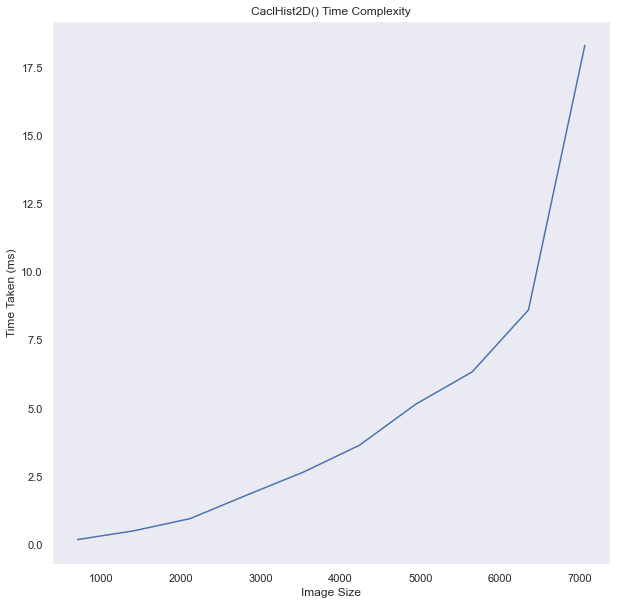

In [69]:
import time

calchist_times = []
sizes = []
num_tries = 100


img = cv2.imread('data/img.jpeg',0)
h, w = img.shape
for i in range(10):
    print(i)
    # resize image
    img_resized = cv2.resize(cv2.imread('data/img.jpeg',0), (w*(i+1),h*(i+1)))

    avg_time = 0
    for t in range(num_tries):
        # time otsu thresholding
        start = time.perf_counter_ns()
        hist = cv2.calcHist([img_resized],[0],None,[256],[0,256])
        end = time.perf_counter_ns()
        avg_time += (end - start)*1e-6/num_tries

    calchist_times.append(avg_time)
    sizes.append(img_resized.shape[0])

plt.figure(figsize=(10,10))
plt.plot(sizes, calchist_times)
plt.xlabel('Image Size')
plt.ylabel('Time Taken (ms)')
plt.title('CaclHist2D() Time Complexity')
plt.show()


0
1
2
3
4
5
6
7
8
9


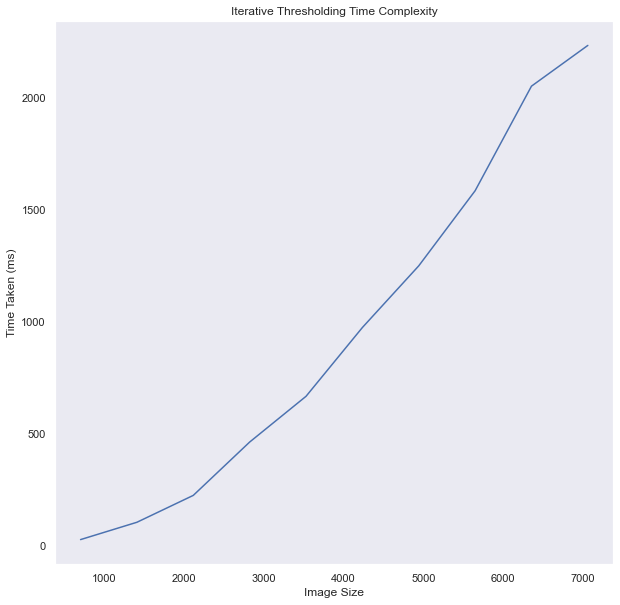

In [68]:
import time

iterative_times = []
sizes = []
num_tries = 5


img = cv2.imread('data/img.jpeg',0)
h, w = img.shape
for i in range(10):
    print(i)
    # resize image
    img_resized = cv2.resize(cv2.imread('data/img.jpeg',0), (w*(i+1),h*(i+1)))

    avg_time = 0
    for t in range(num_tries):
        # time otsu thresholding
        start = time.perf_counter_ns()
        # hist = cv2.calcHist([img_resized],[0],None,[256],[0,256])
        thresh = iterative_method_thresholding_no_ret(img_resized)
        end = time.perf_counter_ns()
        avg_time += (end - start)*1e-6/num_tries

    iterative_times.append(avg_time)
    sizes.append(img_resized.shape[0])

plt.figure(figsize=(10,10))
plt.plot(sizes, iterative_times)
plt.xlabel('Image Size')
plt.ylabel('Time Taken (ms)')
plt.title('Iterative Thresholding Time Complexity')
plt.show()


### Otsu vs Iterative

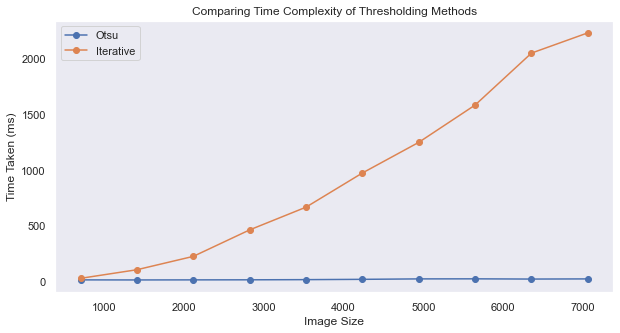

In [91]:
plt.figure(figsize=(10,5))
plt.plot(sizes, otsu_times[:len(sizes)], label='Otsu', marker='o')
plt.plot(sizes, iterative_times, label='Iterative', marker='o')
plt.xlabel('Image Size')
plt.ylabel('Time Taken (ms)')
plt.title('Comparing Time Complexity of Thresholding Methods')
plt.legend()
plt.show()

### Otsu vs CaclHist vs Iterative

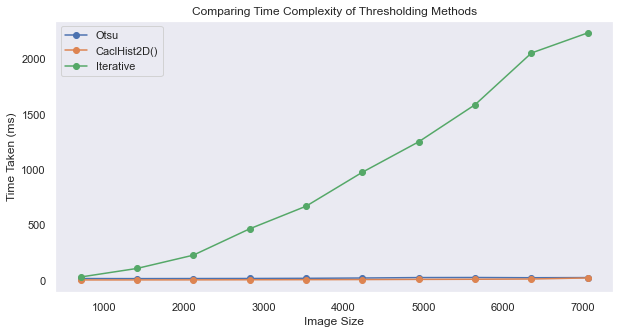

In [90]:
plt.figure(figsize=(10,5))
plt.plot(sizes, otsu_times[:len(sizes)], label='Otsu', marker='o')
plt.plot(sizes, calchist_times, label='CaclHist2D()', marker='o')
plt.plot(sizes, iterative_times, label='Iterative', marker='o')
plt.xlabel('Image Size')
plt.ylabel('Time Taken (ms)')
plt.title('Comparing Time Complexity of Thresholding Methods')
plt.legend()
plt.show()

### Otsu vs CaclHist

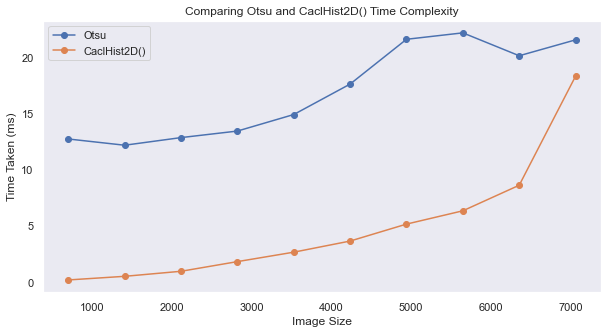

In [89]:
plt.figure(figsize=(10,5))
plt.plot(sizes, otsu_times[:len(sizes)], label='Otsu', marker='o')
plt.plot(sizes, calchist_times, label='CaclHist2D()', marker='o')
plt.xlabel('Image Size')
plt.ylabel('Time Taken (ms)')
plt.title('Comparing Otsu and CaclHist2D() Time Complexity')
plt.legend()
plt.show()

### Otsu vs Iterative vs CaclHist log scale

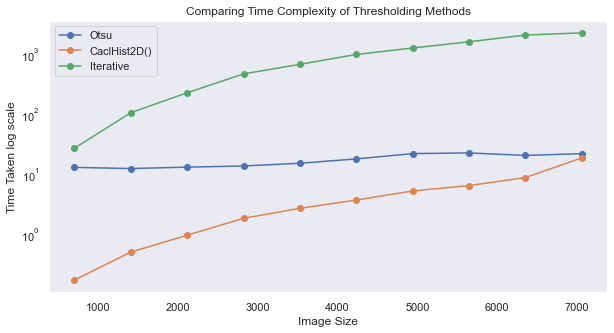

In [88]:
plt.figure(figsize=(10,5))
plt.plot(sizes, otsu_times[:len(sizes)], label='Otsu', marker='o')
plt.plot(sizes, calchist_times, label='CaclHist2D()', marker='o')
plt.plot(sizes, iterative_times, label='Iterative', marker='o')
plt.xlabel('Image Size')
plt.ylabel('Time Taken log scale')
plt.title('Comparing Time Complexity of Thresholding Methods')
plt.yscale('log')
plt.legend()
plt.show()

Converged to t=151.32107552562653 after 7 iterations
Otsu Threshold:  141
Iterative Threshold:  151.32107552562653


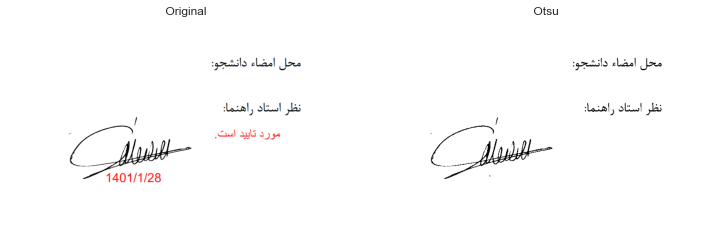

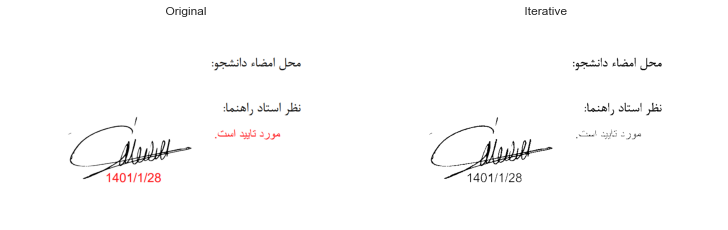

In [168]:
## comparing otsu and iterative

# image_3 = cv2.imread(r'C:\Users\GHD\Pictures\aaaaaaaa.png',0)
image_2 = cv2.imread('data\img2.png',0)
image_2_rgb = rgb(cv2.imread('data\img2.png'))
# image_3[246:300, 488:679] = np.clip(image_3[246:300, 488:679]*2.1, 0, 255)
# print(np.clip(image_3[246:300, 488:679] + 50, 0, 255))
thresh, ret = otsu_thresholding(image_2)
thresh2, ret2 = iterative_method_thresholding(image_2)

print('Otsu Threshold: ', thresh)
print('Iterative Threshold: ', thresh2)
before_after(image_2_rgb, ret, '', effect_name="Otsu", figsize=(10,10))
before_after(image_2_rgb, ret2, '', effect_name="Iterative", figsize=(10,10))

### CelebA datast

In [ ]:
CELEBA_PATH = ""

In [171]:
import glob

def get_images(path):
    images = []
    for filename in glob.glob(path):
        img = cv2.imread(filename,0)
        if img is not None:
            images.append(img)
    return images

# CelebA dataset
images = get_images(CELEBA_PATH+'*.jpg')


Otsu: 91, Iterative: 123.45540834343086


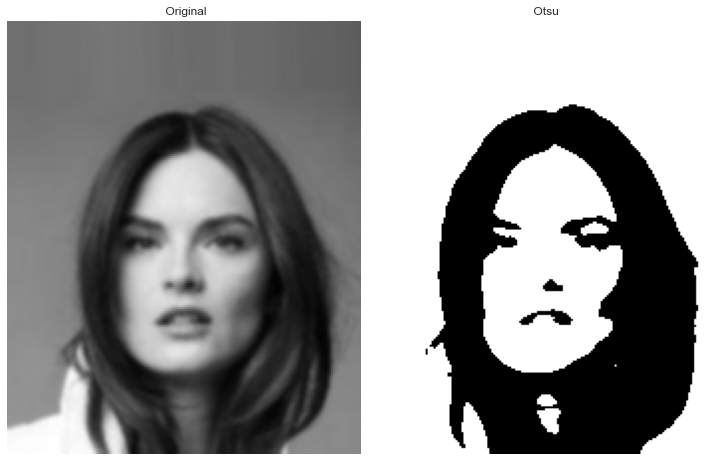

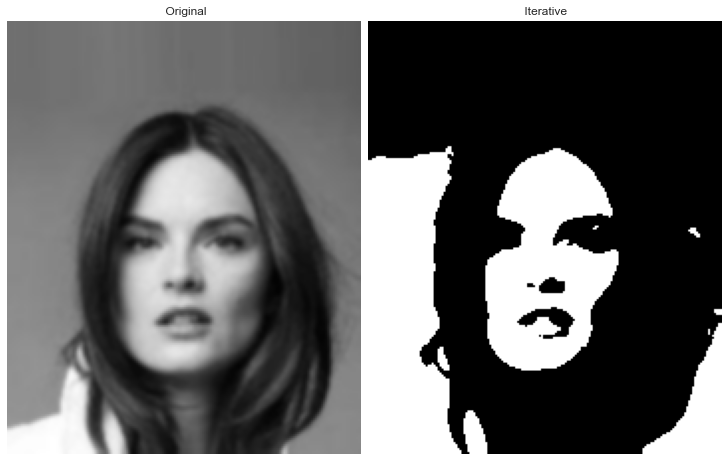

Otsu: 105, Iterative: 78.41490942640817


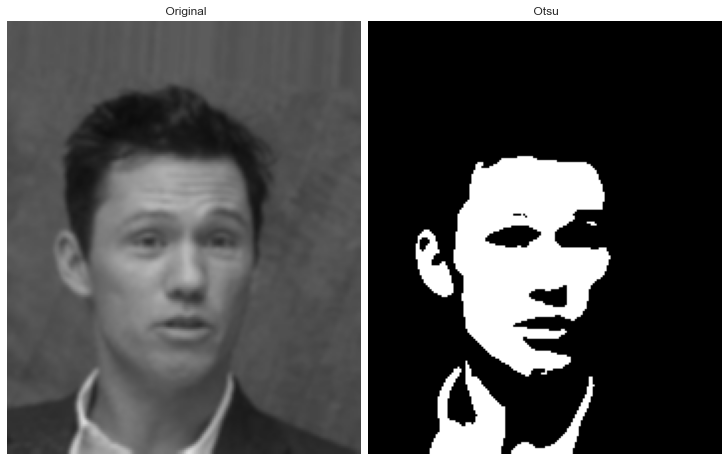

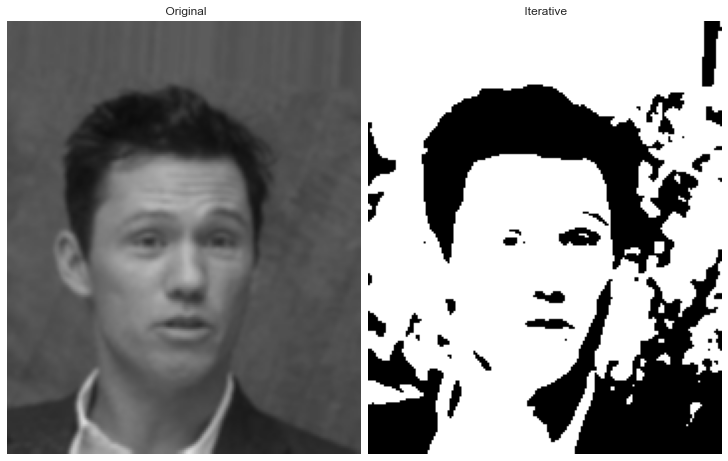

Otsu: 75, Iterative: 100.94388541083597


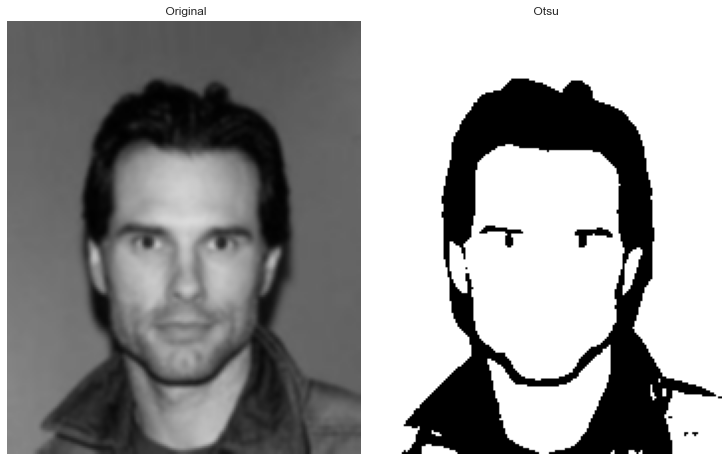

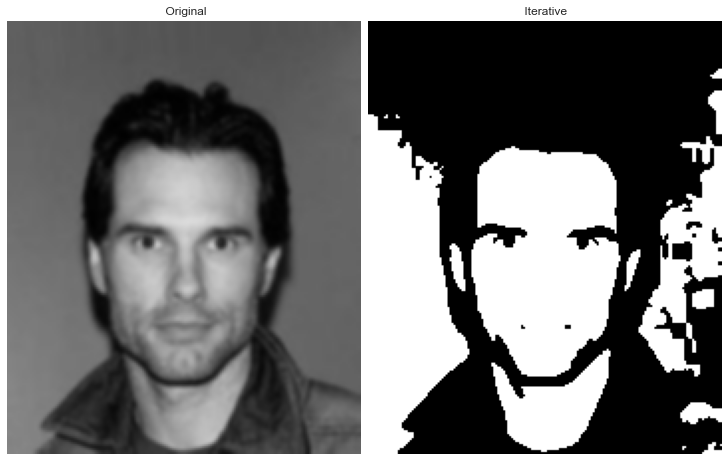

Otsu: 90, Iterative: 67.84096881262836


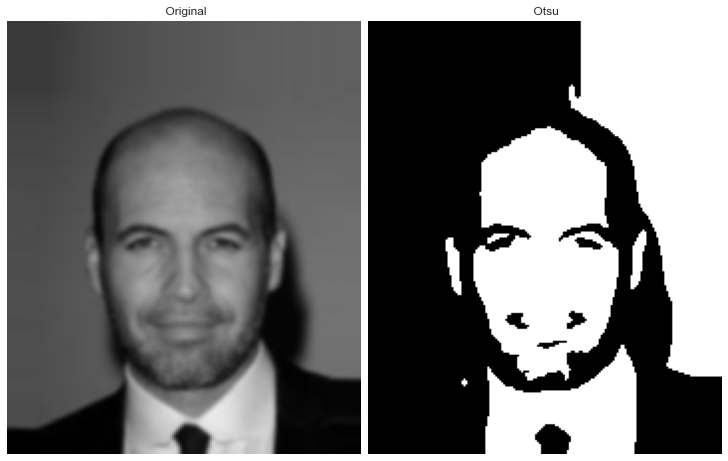

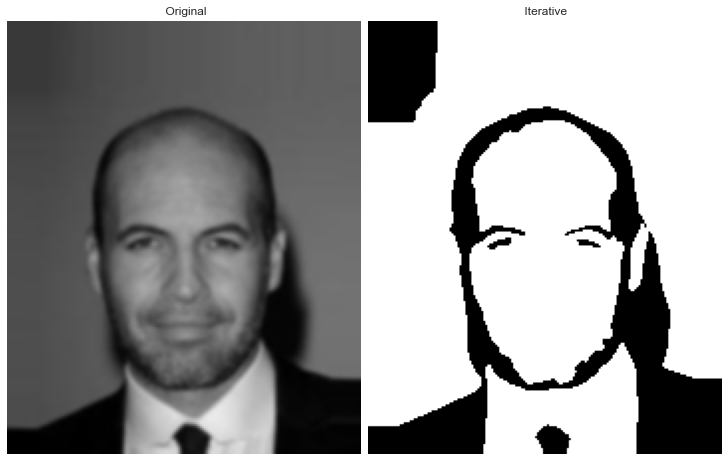

Otsu: 139, Iterative: 177.01068894073256


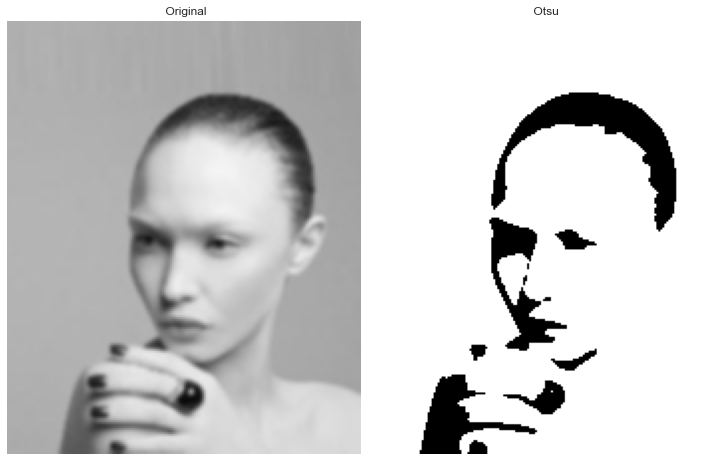

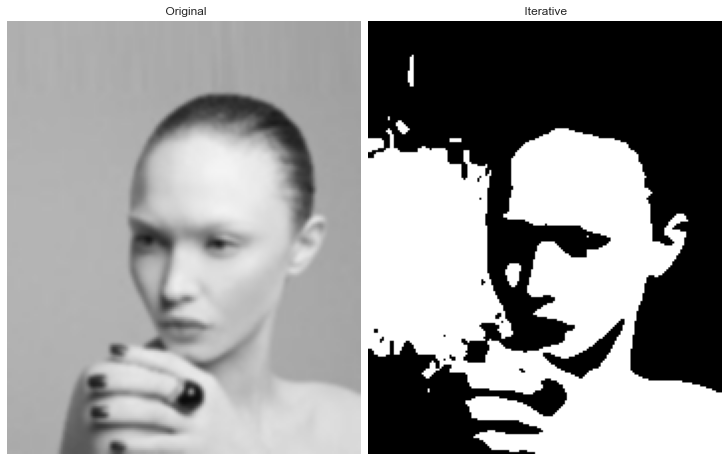

In [181]:
counter= 0
for image in images:
    # blur the image 5x5
    image = cv2.GaussianBlur(image, (5,5), 0)
    thresh, ret = otsu_thresholding(image)
    thresh2, ret2 = iterative_method_thresholding(image, debug=False)
    if abs(thresh-thresh2) > 5:
        print(f"Otsu: {thresh}, Iterative: {thresh2}")
        # before_after(ret, ret2,)
        # print('Iterative Threshold: ', thresh2)
        before_after(rgb(image), ret, '', effect_name="Otsu", figsize=(10,10))
        before_after(rgb(image), ret2, '', effect_name="Iterative", figsize=(10,10))
        counter += 1
    if counter > 4:
        break